In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

# load the model used for prediction the external contour
ex_cnt_model = tf.keras.models.load_model('external_mask_unet_model')
in_cnt_model = tf.keras.models.load_model('internal_smaller_mask_unet_model')

In [2]:
# load the image
original_images_dir = 'data/original/'
heatmap_images_dir = 'data/heatmap/'
tif_images_dir = "C:/Users/jonat/Downloads/EBM6-TI-6AL-4V-SEM-20240705T084323Z-002/EBM6-TI-6AL-4V-SEM"

In [3]:
import numpy as np
import tensorflow as tf

def get_contour(mask: np.ndarray):
    # Apply thresholding
    ret, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    # Find contour using the eroded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Find the contour with the largest area
    contour = max(contours, key=cv2.contourArea)
    return contour

def predict_mask(img, model):
    # Predict the mask
    img = cv2.resize(img, (128, 128))
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)
    img = img / 255
    pred = model.predict(img)
    pred = tf.argmax(pred, axis=-1)
    pred = pred[..., tf.newaxis]
    pred = tf.squeeze(pred)
    pred = pred.numpy()
    pred = pred.astype(np.uint8) * 255
    return pred

In [4]:
def get_heatmap(img, contour):
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # create a mask with the contour
    mask = np.zeros(img_grey.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1, cv2.LINE_AA)
    #######################
    out = np.zeros_like(img)
    out[mask == 255] = img[mask == 255]
    img_color = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
    ######################
    img_grey = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(img_grey, (13,13), 0)
    #edges = cv2.Canny(blur, 50, 150)
    # Run Sobel filter on the original image
    sobelx = cv2.Sobel(blur, cv2.CV_8U, 1, 0, ksize=5)
    sobely = cv2.Sobel(blur, cv2.CV_8U, 0, 1, ksize=5)
    # Find the magnitude of the gradient
    sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)
    # Normalize the image
    sobel_magnitude = sobel_magnitude/sobel_magnitude.max()*255
    # Convert to uint8
    sobel_magnitude = np.uint8(sobel_magnitude)

    window_size = 201 # Odd number only
    window_step = 10

    heat_map_sobel = np.zeros(sobel_magnitude.shape, dtype=np.uint8)

    # pad the images with zeros
    sobel_c = np.pad(sobel_magnitude, int((window_size-1)/2), mode='constant', constant_values=0)
    mask_metal_c = np.pad(mask, int((window_size-1)/2), mode='constant', constant_values=0)

    for y in range(0, sobel_c.shape[0], window_step):
        for x in range(0, sobel_c.shape[1], window_step):
            window = sobel_c[y:y+window_size, x:x+window_size]
            mask_metal_window = mask_metal_c[y:y+window_size, x:x+window_size]/255
            if mask_metal_window.sum() == 0 or mask_metal_window[(int((window_size - 1) / 2)), (int((window_size - 1) / 2))] == 0:
                heat_map_sobel[y:y+window_size, x:x+window_size] = 0
            else:
                heat_map_sobel[y:y+window_step, x:x+window_step] = np.sum(window)/mask_metal_window.sum()

    heat_map_sobel = cv2.equalizeHist(heat_map_sobel)

    # # apply a threshold to remove low-intensity values
    # threshold = 50
    # heat_map_sobel[heat_map_sobel < threshold] = 0

    # Save the image with color map
    heat_map_sobel_tmp = heat_map_sobel.copy()
    heat_map_color_sobel = cv2.applyColorMap(heat_map_sobel_tmp, cv2.COLORMAP_JET)
    heat_map_color_sobel_rgb = cv2.applyColorMap(heat_map_color_sobel, cv2.COLOR_BGR2RGB)
    return heat_map_color_sobel


In [5]:
def crop_image(img, contour):
    # Create a mask with the contour
    mask = np.zeros(img.shape, np.uint8)
    cv2.drawContours(mask, [contour], -1, (255, 255, 255), -1, cv2.LINE_AA)
    # Apply the mask to the image
    img = cv2.bitwise_and(img, mask)
    return img

In [6]:
import cv2
import numpy as np
from shapely.geometry import Polygon

def read_image(file_path):
    return cv2.imread(file_path)

def find_center_of_mass(contour, color_img):
    # Find the center of mass of the contour
    hull = cv2.convexHull(contour)
    ellipse = cv2.fitEllipse(hull)
    (x, y), (MA, ma), angle = ellipse
    return (int(x), int(y))

def find_center_of_mass2(contour):
    # Find the center of mass of the contour
    hull = cv2.convexHull(contour)
    M = cv2.minEnclosingCircle(hull)
    return (int(M[0][0]), int(M[0][1]))

def calculate_vector(center1, center2):
    return (center2[0] - center1[0], center2[1] - center1[1])

def is_point_near_line(point, line_start, line_end, eps1):
    # Convert tuples to numpy arrays
    point = np.array(point)
    line_start = np.array(line_start)
    line_end = np.array(line_end)
    eps = eps1

    # Calculate the directional vector of the line
    line_vec = line_end - line_start

    # Calculate the vector from the start of the line to the point
    point_vec = point - line_start

    # Calculate the cross product and the norm
    cross_prod = np.cross(line_vec, point_vec)
    norm_line_vec = np.linalg.norm(line_vec)

    # Calculate the distance from the point to the line
    distance = np.linalg.norm(cross_prod) / norm_line_vec

    # Check if the distance is within the threshold
    if abs(distance) <= eps:
        return True
    else:
        return False

def find_points_near_line(points, line_start, line_end, eps1):
    step=0.1
    max_eps=10
    # Initialize an empty list to store points near the line
    points_near_line = []

    # Temporary variable for the current eps1 value
    current_eps = eps1

    # Loop until at least one point is found or max_eps is reached
    while len(points_near_line) < 1000  and current_eps <= max_eps:
        # Iterate through each point in the list
        for point in points:
            # Check if the point is near the line
            if is_point_near_line(point, line_start, line_end, current_eps):
                # If the point is near the line, add it to the list
                points_near_line.append(point)

        # Increase current_eps for the next iteration
        current_eps += step

    # Return the list of points near the line as a numpy array
    return np.array(points_near_line)

def is_point_on_left_or_right_side(point, line_start, line_end):
    # Convert tuples to numpy arrays
    point = np.array(point)
    line_start = np.array(line_start)
    line_end = np.array(line_end)

    # Calculate the vector representing the original line
    original_line_vector = line_end - line_start

    # Calculate the orthogonal line vector (rotate original line by 90 degrees)
    orthogonal_line_vector = np.array([-original_line_vector[1], original_line_vector[0]])

    # Define the end point of the new line, extending the orthogonal line from line_start
    new_line_end = line_start + orthogonal_line_vector

    # Calculate the vector from the start of the new line to the point
    point_vector = point - line_start

    # Calculate the vector representing the new line
    new_line_vector = new_line_end - line_start

    # Calculate the cross product (in 2D, it's a scalar)
    cross_prod = np.cross(new_line_vector, point_vector)

    # Determine the side based on the sign of the cross product
    if cross_prod > 0:
        return 'left'
    else:
        return 'right'

def find_farthest_point(contour, center, axis_angle):
    """Find the farthest point on the contour from the center along a specified axis."""
    farthest_distance = 0
    for point in contour:
        # Project each point onto the specified axis
        vector = np.array(point[0]) - np.array(center)
        axis_vector = np.array([np.cos(np.radians(axis_angle)), np.sin(np.radians(axis_angle))])
        distance = np.dot(vector, axis_vector)
        farthest_distance = max(farthest_distance, abs(distance))
    return farthest_distance

def adjust_ellipse(contour, new_center, vector):
    new_center = new_center[0]
    # Fit initial ellipse
    ellipse = cv2.fitEllipse(contour)
    (x, y), (MA, ma), angle = ellipse
    angle = np.degrees(np.arctan2(vector[1], vector[0]), dtype=np.float32)

    # Calculate the farthest point on the contour from the center along the specified axis
    farthest_distance = find_farthest_point(contour, new_center, angle)

    # Calculate new major and minor axes lengths
    new_major_axis = ma * (ma / MA)
    new_minor_axis = farthest_distance  * 2

    # Update the ellipse with the new parameters
    ellipse = (new_center, (new_minor_axis, new_major_axis), angle)

    return ellipse, farthest_distance

def find_ellipse(in_cnt, ex_cnt):
    ex_cnt_center = find_center_of_mass2(ex_cnt)
    in_cnt_center = find_center_of_mass(in_cnt, cv2.resize(heatmap_img, (128, 128)))

    vector = calculate_vector(ex_cnt_center, in_cnt_center)

    # Find points near the line
    eps1 = 0.1
    points_near_line = find_points_near_line(ex_cnt, ex_cnt_center, in_cnt_center, eps1)

    # Find points on the left and right side of the line
    left_points = []
    right_points = []
    for point in points_near_line:
        if is_point_on_left_or_right_side(point, ex_cnt_center, in_cnt_center) == 'left':
            left_points.append(point)
        else:
            right_points.append(point)

    left_points = np.array(left_points)
    right_points = np.array(right_points)

    # Check if the center of mass of the internal contour is on the left or right side of the line
    side = is_point_on_left_or_right_side(in_cnt_center, ex_cnt_center, in_cnt_center)
    if side == 'left':
        points = left_points
    else:
        points = right_points

    sample_point = points[0]

    ellipse, farthest_distance = adjust_ellipse(in_cnt, sample_point, vector)

    return ellipse, farthest_distance

def linear_interpolation(contour):
    new_contour = []
    for i in range(len(contour)):
        p1 = contour[i]
        p2 = contour[(i + 1) % len(contour)]  # Circular connection
        mid_point = (p1 + p2) / 2
        new_contour.extend([p1, mid_point])
    return np.array(new_contour)

In [20]:
import os
directories = ['test', 'train']

# Create an pdf file to save the results
from fpdf import FPDF
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)

i = 0
for directory in directories:
    for img_name in os.listdir(original_images_dir + directory):
        original_img = read_image(original_images_dir + directory + '/' + img_name)
        heatmap_img = read_image(heatmap_images_dir + directory + '/' + img_name)
        ex_cnt_mask = predict_mask(original_img, ex_cnt_model)
        in_cnt_mask = predict_mask(heatmap_img, in_cnt_model)
        int_mask = cv2.GaussianBlur(in_cnt_mask, (7, 7), 0)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        int_mask = cv2.dilate(int_mask, kernel, iterations=1)
        ex_cnt = get_contour(ex_cnt_mask)
        in_cnt = get_contour(in_cnt_mask)
        ex_cnt = ex_cnt.astype(np.uint8)
        in_cnt = in_cnt.astype(np.uint8)
        factor = int(original_img.shape[0] / 128)
        ex_cnt = linear_interpolation(ex_cnt)
        in_cnt = linear_interpolation(in_cnt)
        ex_cnt = ex_cnt.astype(np.int32)
        in_cnt = in_cnt.astype(np.int32)
        ellipse, farthest_distance = find_ellipse(in_cnt, ex_cnt)
        ellipse = (tuple(map(int, ellipse[0])), tuple(map(int, ellipse[1])), ellipse[2])
        scaled_ellipse = ((ellipse[0][0] * factor, ellipse[0][1] * factor), (ellipse[1][0] * factor, ellipse[1][1] * factor), ellipse[2])
        ex_cnt = ex_cnt * factor
        in_cnt = in_cnt * factor
        # Drawing the ellipse
        ellipse_img = heatmap_img.copy()
        cv2.ellipse(ellipse_img, scaled_ellipse, (0, 255, 0), 50)
        #drawing the external contour
        cv2.drawContours(ellipse_img, [ex_cnt], -1, (0, 0, 255), 50)
        #drawing the internal contour
        cv2.drawContours(ellipse_img, [in_cnt], -1, (255, 0, 0), 50)

        color_line = (255, 255, 255)  # Dodger Blue, for visibility
        thickness_line = 30  # Slightly thinner for elegance
        # Improved text annotation
        font_face = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 15
        font_thickness = 50
        color_text = (255, 255, 255)  # Cyan for contrast with red and visibility

        # Find the radius of the circle of the external contour
        radius = cv2.minEnclosingCircle(ex_cnt)[1]
        
        # Draw the vector on the image of the minor axis with the letter 'a'
        cv2.line(
                    ellipse_img,
                    (int(scaled_ellipse[0][0]), int(scaled_ellipse[0][1])),
                    (int(scaled_ellipse[0][0] + scaled_ellipse[1][1] / 2 * np.cos(np.radians(scaled_ellipse[2] + 270))),
                     int(scaled_ellipse[0][1] + scaled_ellipse[1][1] / 2 * np.sin(np.radians(scaled_ellipse[2] + 270)))),
                    color_line,
                    thickness_line
                )
        text_position = (int(scaled_ellipse[0][0] + scaled_ellipse[1][1] / 2 * np.cos(np.radians(scaled_ellipse[2] + 270))),
                         int(scaled_ellipse[0][1] + scaled_ellipse[1][1] / 2 * np.sin(np.radians(scaled_ellipse[2] + 270))))
        cv2.putText(ellipse_img, 'b', text_position, font_face, font_scale, color_text, font_thickness)
        # mark in point the end of the line
        cv2.circle(ellipse_img, (int(scaled_ellipse[0][0] + scaled_ellipse[1][1] / 2 * np.cos(np.radians(scaled_ellipse[2] + 270))),
                                int(scaled_ellipse[0][1] + scaled_ellipse[1][1] / 2 * np.sin(np.radians(scaled_ellipse[2] + 270)))), 50, (255, 255, 255), -1)
        # Draw the vector on the image of the major axis with the letter 'b'
        cv2.line(
            ellipse_img,
            (int(scaled_ellipse[0][0]), int(scaled_ellipse[0][1])),
            (int(scaled_ellipse[0][0] + scaled_ellipse[1][0] / 2 * np.cos(np.radians(scaled_ellipse[2] + 180))),
             int(scaled_ellipse[0][1] + scaled_ellipse[1][0] / 2 * np.sin(np.radians(scaled_ellipse[2] + 180)))),
            color_line,
            thickness_line)
        text_position = (int(scaled_ellipse[0][0] + scaled_ellipse[1][0] / 2 * np.cos(np.radians(scaled_ellipse[2] + 180))),
                         int(scaled_ellipse[0][1] + scaled_ellipse[1][0] / 2 * np.sin(np.radians(scaled_ellipse[2] + 180))))
        # do so i can see the annotation
        cv2.putText(ellipse_img, 'a', text_position, font_face, font_scale, color_text, font_thickness)
        # mark in point the end of the line
        cv2.circle(ellipse_img, (int(scaled_ellipse[0][0] + scaled_ellipse[1][0] / 2 * np.cos(np.radians(scaled_ellipse[2] + 180))),
                                int(scaled_ellipse[0][1] + scaled_ellipse[1][0] / 2 * np.sin(np.radians(scaled_ellipse[2] + 180)))), 50, (255, 255, 255), -1)
        
        
        radius = cv2.minEnclosingCircle(ex_cnt)[1]
        
        # Drawing the line in opposite direction of the major axis and length of radius * 2
        cv2.line(
            ellipse_img,
            (int(scaled_ellipse[0][0]), int(scaled_ellipse[0][1])),
            (int(scaled_ellipse[0][0] + radius * 2 * np.cos(np.radians(scaled_ellipse[2] + 180))),
             int(scaled_ellipse[0][1] + radius * 2 * np.sin(np.radians(scaled_ellipse[2] + 180))),
             ),
            color_line,
            thickness_line
        )
        
        cv2.circle(ellipse_img, (int(scaled_ellipse[0][0] + radius * 2 * np.cos(np.radians(scaled_ellipse[2] + 180))),
                                int(scaled_ellipse[0][1] + radius * 2 * np.sin(np.radians(scaled_ellipse[2] + 180)))), 50, (255, 255, 255), -1)
        
        text_position = (int(scaled_ellipse[0][0] + radius * 2 * np.cos(np.radians(scaled_ellipse[2] + 180))),
                         int(scaled_ellipse[0][1] + radius * 2 * np.sin(np.radians(scaled_ellipse[2] + 180))))
        
        
        cv2.putText(ellipse_img, 'D', text_position, font_face, font_scale, color_text, font_thickness)
        
        # Add a description to the image with the ellipse major and minor axes lengths outside image
        b = round(scaled_ellipse[1][1] / 2, 2)
        a = round(scaled_ellipse[1][0] / 2, 2)
        D = round(radius * 2, 2)
        text = 'Major axis (b): ' + str(round(scaled_ellipse[1][1] / 2, 2)) + ' pixels'
        text += '\nMinor axis (a): ' + str(round(scaled_ellipse[1][0] / 2, 2)) + ' pixels'
        text += '\nRadius (D): ' + str(round(radius * 2, 2)) + ' pixels'
        text += '\nFarthest distance (h): ' + str(round(farthest_distance * factor / 2.0, 2)) + ' pixels'
        text1 = '\ninternal contour area: ' + str(round(cv2.contourArea(in_cnt), 2)) + ' pixels'
        text1 += '\nexternal contour area: ' + str(round(cv2.contourArea(ex_cnt), 2)) + ' pixels'
        text1 += '\nratio: ' + str(round(cv2.contourArea(in_cnt) / cv2.contourArea(ex_cnt), 2))
        text1 += '\n'
        

        # plt.show()
        pdf.cell(200, 10, txt=img_name, ln=1, align="C")
        pdf.multi_cell(100, 10, text)  # Width of 100 and height of 10 for each line
        end_y = pdf.get_y()
        pdf.set_xy(100, 10 + pdf.get_y() - pdf.font_size * len(text.split("\n")) * 10 / pdf.k)
        pdf.multi_cell(100, 10, text1)  #
        # reduce the size of the image
        ellipse_img = cv2.resize(ellipse_img, (0, 0), fx=0.5, fy=0.5)
        # Save the image in tmp file
        cv2.imwrite('tmp' + img_name + '.png', ellipse_img)
        # Add the image to pdf file
        pdf.image('tmp' + img_name + '.png', x=50, y=60, w=100)
        # Add new page
        pdf.add_page()
        os.remove('tmp' + img_name + '.png')
    
# Save the pdf file
pdf.output("ellipses.pdf")

1/1 [==============================] - 0s 83ms/step


''

In [62]:
import os
import cv2
from fpdf import FPDF
import numpy as np
import uuid
import matplotlib.pyplot as plt

def find_intersection_over_union(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# Function to save an image with axes and optional title
def save_with_axes(image, filename, title=''):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title(title)
    # ax.set_xticks([])  # Remove x-axis ticks; remove this line if you want to show ticks
    # ax.set_yticks([])  # Remove y-axis ticks; remove this line if you want to show ticks
    plt.axis('on')  # Display the axes; change to 'off' to hide axes
    plt.savefig(filename, bbox_inches='tight')
    plt.close(fig)  # Close the figure to free up memory

# PDF settings
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.set_font("Arial", size=12)

directories = ['test']
internal_contour_masks_dir = "internal_bigger_masks"

# Process each image in the directories
for directory in directories:
    image_list = os.listdir(os.path.join(original_images_dir, directory))
    for img_name in image_list:
        original_img_path = os.path.join(original_images_dir, directory, img_name)
        heatmap_img_path = os.path.join(heatmap_images_dir, directory, img_name)
        int_cnt_mask_path = os.path.join(internal_contour_masks_dir, directory, img_name)

        original_img = cv2.imread(original_img_path)
        heatmap_img = cv2.imread(heatmap_img_path)
        
        # resize by 0.25
        original_img = cv2.resize(original_img, (0, 0), fx=1, fy=1)
        heatmap_img = cv2.resize(heatmap_img, (0, 0), fx=1, fy=1)

        if original_img is None or heatmap_img is None:
            continue

        # Placeholder for your actual mask prediction and contour functions
        ex_cnt_mask = predict_mask(original_img, ex_cnt_model)  # Implement this function
        in_cnt_mask = predict_mask(heatmap_img, in_cnt_model)  # Implement this function
        ex_cnt = get_contour(ex_cnt_mask)  # Implement this function
        in_cnt = get_contour(in_cnt_mask)  # Implement this function

        ex_cnt = ex_cnt.astype(np.uint8)
        in_cnt = in_cnt.astype(np.uint8)
        factor = int(original_img.shape[0] / 128)
        ex_cnt = linear_interpolation(ex_cnt)  # Implement this function
        in_cnt = linear_interpolation(in_cnt)  # Implement this function
        ex_cnt = ex_cnt.astype(np.int32)
        in_cnt = in_cnt.astype(np.int32)
        try:
            ellipse, farthest_distance = find_ellipse(in_cnt, ex_cnt)
        except:
            continue
        ellipse = (tuple(map(int, ellipse[0])), tuple(map(int, ellipse[1])), ellipse[2])
        scaled_ellipse = ((ellipse[0][0] * factor, ellipse[0][1] * factor), (ellipse[1][0] * factor, ellipse[1][1] * factor), ellipse[2])
        ex_cnt = ex_cnt * factor
        in_cnt = in_cnt * factor
        
        true_internal_mask = cv2.imread(int_cnt_mask_path, cv2.IMREAD_GRAYSCALE)
        true_internal_contour = get_contour(true_internal_mask)
        radius = cv2.minEnclosingCircle(ex_cnt)[1]
        true_internal_mask_low_res = cv2.resize(true_internal_mask, (128, 128))

        # Draw contours on copies of the images
        original_with_internal = cv2.drawContours(original_img.copy(), [in_cnt], -1, (255, 0, 0), 10)
        heatmap_with_internal = cv2.drawContours(heatmap_img.copy(), [in_cnt], -1, (255, 0, 0), 10)
        original_with_labeled = cv2.drawContours(original_img.copy(), [true_internal_contour], -1, (255, 0, 0), 10)
        heatmap_with_labeled = cv2.drawContours(heatmap_img.copy(), [true_internal_contour], -1, (255, 0, 0), 10)
        
        # Adding text to images with increased font size
        # do the fontscale relative to the size of the image
        # cv2.putText(original_img, 'Original Image', (10, 240), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 0), 20, cv2.LINE_AA)
        # cv2.putText(heatmap_img, 'Heatmap Image', (10, 240), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 0), 20, cv2.LINE_AA)
        # cv2.putText(original_with_internal, 'Internal Contour on Original', (10, 240), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 0), 20, cv2.LINE_AA)
        # cv2.putText(heatmap_with_internal, 'Internal Contour on Heatmap', (10, 240), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 0), 20, cv2.LINE_AA)
        # cv2.putText(original_with_labeled, 'Labeled Internal Contour on Original', (10, 240), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 0), 20, cv2.LINE_AA)
        # cv2.putText(heatmap_with_labeled, 'Labeled Internal Contour on Heatmap', (10, 240), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 0), 20, cv2.LINE_AA)
        
        # Save temporary images
        unique_id = str(uuid.uuid4())
        temp_images = [
            f'original_img_{unique_id}.jpg',
            f'heatmap_img_{unique_id}.jpg',
            f'original_with_internal_{unique_id}.jpg',
            f'heatmap_with_internal_{unique_id}.jpg',
            f'original_with_labeled_{unique_id}.jpg',
            f'heatmap_with_labeled_{unique_id}.jpg'
        ]
        
        # Example usage: Save images with axes
        save_with_axes(original_img, temp_images[0], title='Original Image')
        save_with_axes(heatmap_img, temp_images[1], title='Heatmap Image')
        save_with_axes(original_with_internal, temp_images[2], title='Original with Internal Contour')
        save_with_axes(heatmap_with_internal, temp_images[3], title='Heatmap with Internal Contour')
        save_with_axes(original_with_labeled, temp_images[4], title='Original with Labeled Contour')
        save_with_axes(heatmap_with_labeled, temp_images[5], title='Heatmap with Labeled Contour')
        
        # cv2.imwrite(temp_images[0], original_img)
        # cv2.imwrite(temp_images[1], heatmap_img)
        # cv2.imwrite(temp_images[2], original_with_internal)
        # cv2.imwrite(temp_images[3], heatmap_with_internal)
        # cv2.imwrite(temp_images[4], original_with_labeled)
        # cv2.imwrite(temp_images[5], heatmap_with_labeled)

        # Add images and text to PDF
        pdf.add_page()
        pdf.cell(200, 10, txt=img_name, ln=1, align="C")

        for idx, temp_image in enumerate(temp_images):
            position_x = 10 if idx % 2 == 0 else 110
            position_y = 30 + (idx // 2) * 90
            pdf.image(temp_image, x=position_x, y=position_y, w=90)
            # if idx % 2 == 0:
            #     pdf.cell(100, 10, txt=['Original', 'Heatmap', 'Original with Internal Contour', 'Heatmap with Internal Contour', 'Original with Labeled Contour', 'Heatmap with Labeled Contour'][idx//2], ln=5, align="C")
            pdf.ln(15)
            
            
        # new page
        pdf.add_page()
        
        # Drawing the ellipse
        ellipse_img = heatmap_img.copy()
        
        cv2.ellipse(ellipse_img, scaled_ellipse, (0, 255, 0), 50)
        #drawing the external contour
        cv2.drawContours(ellipse_img, [ex_cnt], -1, (0, 0, 255), 50)
        #drawing the internal contour
        cv2.drawContours(ellipse_img, [in_cnt], -1, (255, 0, 0), 50)
        # padding the ellipse_img to resolution of 10000x10000 and keep the 4096on 4096 on the center
        ellipse_img = cv2.copyMakeBorder(ellipse_img, 2900, 2900, 2900, 2900, cv2.BORDER_CONSTANT, value=(0, 0, 0))
        ellipse = scaled_ellipse
        scaled_ellipse = (ellipse[0][0] + 2900, ellipse[0][1] + 2900), ellipse[1], ellipse[2]
        

        color_line = (255, 255, 255)  # Dodger Blue, for visibility
        thickness_line = 30  # Slightly thinner for elegance
        # Improved text annotation
        font_face = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 15
        font_thickness = 50
        color_text = (255, 255, 255)  # Cyan for contrast with red and visibility

        # Find the radius of the circle of the external contour
        radius = cv2.minEnclosingCircle(ex_cnt)[1]
        
        # Draw the vector on the image of the minor axis with the letter 'a'
        cv2.line(
                    ellipse_img,
                    (int(scaled_ellipse[0][0]), int(scaled_ellipse[0][1])),
                    (int(scaled_ellipse[0][0] + scaled_ellipse[1][1] / 2 * np.cos(np.radians(scaled_ellipse[2] + 270))),
                     int(scaled_ellipse[0][1] + scaled_ellipse[1][1] / 2 * np.sin(np.radians(scaled_ellipse[2] + 270)))),
                    color_line,
                    thickness_line
                )
        text_position = (int(scaled_ellipse[0][0] + scaled_ellipse[1][1] / 2 * np.cos(np.radians(scaled_ellipse[2] + 270))),
                         int(scaled_ellipse[0][1] + scaled_ellipse[1][1] / 2 * np.sin(np.radians(scaled_ellipse[2] + 270))))
        cv2.putText(ellipse_img, 'b', text_position, font_face, font_scale, color_text, font_thickness)
        # mark in point the end of the line
        cv2.circle(ellipse_img, (int(scaled_ellipse[0][0] + scaled_ellipse[1][1] / 2 * np.cos(np.radians(scaled_ellipse[2] + 270))),
                                int(scaled_ellipse[0][1] + scaled_ellipse[1][1] / 2 * np.sin(np.radians(scaled_ellipse[2] + 270)))), 50, (255, 255, 255), -1)
        # Draw the vector on the image of the major axis with the letter 'b'
        cv2.line(
            ellipse_img,
            (int(scaled_ellipse[0][0]), int(scaled_ellipse[0][1])),
            (int(scaled_ellipse[0][0] + scaled_ellipse[1][0] / 2 * np.cos(np.radians(scaled_ellipse[2] + 180))),
             int(scaled_ellipse[0][1] + scaled_ellipse[1][0] / 2 * np.sin(np.radians(scaled_ellipse[2] + 180)))),
            color_line,
            thickness_line)
        text_position = (int(scaled_ellipse[0][0] + scaled_ellipse[1][0] / 2 * np.cos(np.radians(scaled_ellipse[2] + 180))),
                         int(scaled_ellipse[0][1] + scaled_ellipse[1][0] / 2 * np.sin(np.radians(scaled_ellipse[2] + 180))))
        # do so i can see the annotation
        cv2.putText(ellipse_img, 'a', text_position, font_face, font_scale, color_text, font_thickness)
        # mark in point the end of the line
        cv2.circle(ellipse_img, (int(scaled_ellipse[0][0] + scaled_ellipse[1][0] / 2 * np.cos(np.radians(scaled_ellipse[2] + 180))),
                                int(scaled_ellipse[0][1] + scaled_ellipse[1][0] / 2 * np.sin(np.radians(scaled_ellipse[2] + 180)))), 50, (255, 255, 255), -1)
        
        
        radius = cv2.minEnclosingCircle(ex_cnt)[1]
        
        # Drawing the line in opposite direction of the major axis and length of radius * 2
        cv2.line(
            ellipse_img,
            (int(scaled_ellipse[0][0]), int(scaled_ellipse[0][1])),
            (int(scaled_ellipse[0][0] + radius * 2 * np.cos(np.radians(scaled_ellipse[2] + 180))),
             int(scaled_ellipse[0][1] + radius * 2 * np.sin(np.radians(scaled_ellipse[2] + 180))),
             ),
            color_line,
            thickness_line
        )
        
        cv2.circle(ellipse_img, (int(scaled_ellipse[0][0] + radius * 2 * np.cos(np.radians(scaled_ellipse[2] + 180))),
                                int(scaled_ellipse[0][1] + radius * 2 * np.sin(np.radians(scaled_ellipse[2] + 180)))), 50, (255, 255, 255), -1)
        
        text_position = (int(scaled_ellipse[0][0] + radius * 2 * np.cos(np.radians(scaled_ellipse[2] + 180))),
                         int(scaled_ellipse[0][1] + radius * 2 * np.sin(np.radians(scaled_ellipse[2] + 180))))
        
        
        cv2.putText(ellipse_img, 'D', text_position, font_face, font_scale, color_text, font_thickness)
        
        # Prepare the text to overlay on the image
        text = [
            f'Major axis (b): {round(scaled_ellipse[1][1] / 2, 2)} pixels\n',
            f'Minor axis (a): {round(scaled_ellipse[1][0] / 2, 2)} pixels\n',
            f'Radius (D): {round(radius * 2, 2)} pixels\n',
            f'Farthest distance (h): {round(farthest_distance * factor / 2.0, 2)} pixels\n',
            f'Internal contour area: {round(cv2.contourArea(in_cnt), 2)} pixels\n',
            f'External contour area: {round(cv2.contourArea(ex_cnt), 2)} pixels\n',
            f'Ratio: {round(cv2.contourArea(in_cnt) / cv2.contourArea(ex_cnt), 2)}\n'
            f'IOU between predicted and true internal contour: {find_intersection_over_union(true_internal_mask_low_res, in_cnt_mask)}'
        ]

        # Overlay the text onto the ellipse image
        y0, dy = 50, 30  # Starting y position and line height
        
        # Save the annotated ellipse image
        save_with_axes(ellipse_img, f'ellipse_img_{unique_id}.jpg', title='Ellipse Image')

        # Add the ellipse image with text to the PDF
        pdf.image(f'ellipse_img_{unique_id}.jpg', x=10, y=20, w=100, h=100, type='jpg')
        # add the text to the pdf below the image
        pdf.ln(120)
        pdf.multi_cell(0, 10, ' '.join(text))

        # please keep the image in the pdf after the image removes the image
        
        # Clean up temporary images
        for temp_image in temp_images:
            os.remove(temp_image)
        os.remove(f'ellipse_img_{unique_id}.jpg')

# Save the PDF file
pdf.output("ellipses.pdf")

1/1 [==============================] - 0s 63ms/step


''

In [61]:
import os
import uuid

# Create an pdf file to save the results
from fpdf import FPDF
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)

i = 0
for img_name in os.listdir(tif_images_dir):
    # original_img = read_image(original_images_dir + directory + '/' + img_name)
    # heatmap_img = read_image(heatmap_images_dir + directory + '/' + img_name)
    tif_img = read_image(tif_images_dir + '/' + img_name)
    gray = cv2.cvtColor(tif_img, cv2.COLOR_BGR2GRAY)
    _, width = gray.shape
    tif_img = tif_img[0:width, 0:width]
    factor = int(tif_img.shape[0] / 128)
    original_img = tif_img
    ex_cnt_mask = predict_mask(original_img, ex_cnt_model)
    ex_cnt = get_contour(ex_cnt_mask)
    heatmap_img = get_heatmap(original_img, ex_cnt * factor)
    ex_cnt_mask = predict_mask(original_img, ex_cnt_model)
    in_cnt_mask = predict_mask(heatmap_img, in_cnt_model)
    int_mask = cv2.GaussianBlur(in_cnt_mask, (7, 7), 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    int_mask = cv2.dilate(int_mask, kernel, iterations=1)
    ex_cnt = get_contour(ex_cnt_mask)
    in_cnt = get_contour(in_cnt_mask)
    ex_cnt = ex_cnt.astype(np.uint8)
    in_cnt = in_cnt.astype(np.uint8)
    factor = int(original_img.shape[0] / 128)
    ex_cnt = linear_interpolation(ex_cnt)
    ex_cnt = linear_interpolation(ex_cnt)
    ex_cnt = linear_interpolation(ex_cnt)
    ex_cnt = linear_interpolation(ex_cnt)
    ex_cnt = linear_interpolation(ex_cnt)
    in_cnt = linear_interpolation(in_cnt)
    in_cnt = linear_interpolation(in_cnt)
    in_cnt = linear_interpolation(in_cnt)
    in_cnt = linear_interpolation(in_cnt)
    in_cnt = linear_interpolation(in_cnt)
    ex_cnt = ex_cnt.astype(np.int32)
    in_cnt = in_cnt.astype(np.int32)
    try:
        ellipse, farthest_distance = find_ellipse(in_cnt, ex_cnt)
    except:
        continue
    ellipse = (tuple(map(int, ellipse[0])), tuple(map(int, ellipse[1])), ellipse[2])
    scaled_ellipse = ((ellipse[0][0] * factor, ellipse[0][1] * factor), (ellipse[1][0] * factor, ellipse[1][1] * factor), ellipse[2])
    ex_cnt = ex_cnt * factor
    in_cnt = in_cnt * factor
    
    # true_internal_mask = cv2.imread(int_cnt_mask_path, cv2.IMREAD_GRAYSCALE)
    # true_internal_contour = get_contour(true_internal_mask)
    # radius = cv2.minEnclosingCircle(ex_cnt)[1]
    # true_internal_mask_low_res = cv2.resize(true_internal_mask, (128, 128))
    
    # Draw contours on copies of the images
    original_with_internal = cv2.drawContours(original_img.copy(), [in_cnt], -1, (255, 0, 0), 10)
    heatmap_with_internal = cv2.drawContours(heatmap_img.copy(), [in_cnt], -1, (255, 0, 0), 10)
    #original_with_labeled = cv2.drawContours(original_img.copy(), [true_internal_contour], -1, (255, 0, 0), 10)
    #heatmap_with_labeled = cv2.drawContours(heatmap_img.copy(), [true_internal_contour], -1, (255, 0, 0), 10)
    
    # Adding text to images with increased font size
    cv2.putText(original_img, 'Original Image', (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 0), 20, cv2.LINE_AA)
    cv2.putText(heatmap_img, 'Heatmap Image', (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 0), 20, cv2.LINE_AA)
    cv2.putText(original_with_internal, 'Internal Contour on Original', (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 0), 20, cv2.LINE_AA)
    cv2.putText(heatmap_with_internal, 'Internal Contour on Heatmap', (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 0), 20, cv2.LINE_AA)
    # cv2.putText(original_with_labeled, 'Labeled Internal Contour on Original', (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 0), 20, cv2.LINE_AA)
    # cv2.putText(heatmap_with_labeled, 'Labeled Internal Contour on Heatmap', (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 255, 0), 20, cv2.LINE_AA)
    
    
    # Save temporary images
    unique_id = str(uuid.uuid4()) 
    temp_images = [
        f'original_img_{unique_id}.png',
        f'heatmap_img_{unique_id}.png',
        f'original_with_internal_{unique_id}.png',
        f'heatmap_with_internal_{unique_id}.png',
        # 'original_with_labeled.png',
        # 'heatmap_with_labeled.png'
    ]
    
    cv2.imwrite(temp_images[0], original_img)
    cv2.imwrite(temp_images[1], heatmap_img)
    cv2.imwrite(temp_images[2], original_with_internal)
    cv2.imwrite(temp_images[3], heatmap_with_internal)
    # cv2.imwrite(temp_images[4], original_with_labeled)
    # cv2.imwrite(temp_images[5], heatmap_with_labeled)
    
    # Add images and text to PDF
    pdf.add_page()
    pdf.cell(200, 10, txt=img_name, ln=1, align="C")
    
    for idx, temp_image in enumerate(temp_images):
        position_x = 10 if idx % 2 == 0 else 110
        position_y = 30 + (idx // 2) * 90
        pdf.image(temp_image, x=position_x, y=position_y, w=90)
        # if idx % 2 == 0:
        #     pdf.cell(100, 10, txt=['Original', 'Heatmap', 'Original with Internal Contour', 'Heatmap with Internal Contour', 'Original with Labeled Contour', 'Heatmap with Labeled Contour'][idx//2], ln=5, align="C")
        pdf.ln(15)
        
    # new page
    pdf.add_page()
    
    # Drawing the ellipse
    ellipse_img = heatmap_img.copy()
    
    cv2.ellipse(ellipse_img, scaled_ellipse, (0, 255, 0), 50)
    #drawing the external contour
    cv2.drawContours(ellipse_img, [ex_cnt], -1, (0, 0, 255), 50)
    #drawing the internal contour
    cv2.drawContours(ellipse_img, [in_cnt], -1, (255, 0, 0), 50)
    # padding the ellipse_img to resolution of 10000x10000 and keep the 4096on 4096 on the center
    ellipse_img = cv2.copyMakeBorder(ellipse_img, 2952, 2952, 2952, 2952, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    ellipse = scaled_ellipse
    scaled_ellipse = (ellipse[0][0] + 2952, ellipse[0][1] + 2952), ellipse[1], ellipse[2]
    
    
    color_line = (255, 255, 255)  # Dodger Blue, for visibility
    thickness_line = 30  # Slightly thinner for elegance
    # Improved text annotation
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 15
    font_thickness = 50
    color_text = (255, 255, 255)  # Cyan for contrast with red and visibility
    
    # Find the radius of the circle of the external contour
    radius = cv2.minEnclosingCircle(ex_cnt)[1]
    
    # Draw the vector on the image of the minor axis with the letter 'a'
    cv2.line(
                ellipse_img,
                (int(scaled_ellipse[0][0]), int(scaled_ellipse[0][1])),
                (int(scaled_ellipse[0][0] + scaled_ellipse[1][1] / 2 * np.cos(np.radians(scaled_ellipse[2] + 270))),
                 int(scaled_ellipse[0][1] + scaled_ellipse[1][1] / 2 * np.sin(np.radians(scaled_ellipse[2] + 270)))),
                color_line,
                thickness_line
            )
    text_position = (int(scaled_ellipse[0][0] + scaled_ellipse[1][1] / 2 * np.cos(np.radians(scaled_ellipse[2] + 270))),
                     int(scaled_ellipse[0][1] + scaled_ellipse[1][1] / 2 * np.sin(np.radians(scaled_ellipse[2] + 270))))
    cv2.putText(ellipse_img, 'b', text_position, font_face, font_scale, color_text, font_thickness)
    # mark in point the end of the line
    cv2.circle(ellipse_img, (int(scaled_ellipse[0][0] + scaled_ellipse[1][1] / 2 * np.cos(np.radians(scaled_ellipse[2] + 270))),
                            int(scaled_ellipse[0][1] + scaled_ellipse[1][1] / 2 * np.sin(np.radians(scaled_ellipse[2] + 270)))), 50, (255, 255, 255), -1)
    # Draw the vector on the image of the major axis with the letter 'b'
    cv2.line(
        ellipse_img,
        (int(scaled_ellipse[0][0]), int(scaled_ellipse[0][1])),
        (int(scaled_ellipse[0][0] + scaled_ellipse[1][0] / 2 * np.cos(np.radians(scaled_ellipse[2] + 180))),
         int(scaled_ellipse[0][1] + scaled_ellipse[1][0] / 2 * np.sin(np.radians(scaled_ellipse[2] + 180)))),
        color_line,
        thickness_line)
    text_position = (int(scaled_ellipse[0][0] + scaled_ellipse[1][0] / 2 * np.cos(np.radians(scaled_ellipse[2] + 180))),
                     int(scaled_ellipse[0][1] + scaled_ellipse[1][0] / 2 * np.sin(np.radians(scaled_ellipse[2] + 180))))
    # do so i can see the annotation
    cv2.putText(ellipse_img, 'a', text_position, font_face, font_scale, color_text, font_thickness)
    # mark in point the end of the line
    cv2.circle(ellipse_img, (int(scaled_ellipse[0][0] + scaled_ellipse[1][0] / 2 * np.cos(np.radians(scaled_ellipse[2] + 180))),
                            int(scaled_ellipse[0][1] + scaled_ellipse[1][0] / 2 * np.sin(np.radians(scaled_ellipse[2] + 180)))), 50, (255, 255, 255), -1)
    
    
    radius = cv2.minEnclosingCircle(ex_cnt)[1]
    
    # Drawing the line in opposite direction of the major axis and length of radius * 2
    cv2.line(
        ellipse_img,
        (int(scaled_ellipse[0][0]), int(scaled_ellipse[0][1])),
        (int(scaled_ellipse[0][0] + radius * 2 * np.cos(np.radians(scaled_ellipse[2] + 180))),
         int(scaled_ellipse[0][1] + radius * 2 * np.sin(np.radians(scaled_ellipse[2] + 180))),
         ),
        color_line,
        thickness_line
    )
    
    cv2.circle(ellipse_img, (int(scaled_ellipse[0][0] + radius * 2 * np.cos(np.radians(scaled_ellipse[2] + 180))),
                            int(scaled_ellipse[0][1] + radius * 2 * np.sin(np.radians(scaled_ellipse[2] + 180)))), 50, (255, 255, 255), -1)
    
    text_position = (int(scaled_ellipse[0][0] + radius * 2 * np.cos(np.radians(scaled_ellipse[2] + 180))),
                     int(scaled_ellipse[0][1] + radius * 2 * np.sin(np.radians(scaled_ellipse[2] + 180))))
    
    
    cv2.putText(ellipse_img, 'D', text_position, font_face, font_scale, color_text, font_thickness)
    
    # Prepare the text to overlay on the image
    text = [
        f'Major axis (b): {round(scaled_ellipse[1][1] / 2, 2)} pixels\n',
        f'Minor axis (a): {round(scaled_ellipse[1][0] / 2, 2)} pixels\n',
        f'Radius (D): {round(radius * 2, 2)} pixels\n',
        f'Farthest distance (h): {round(farthest_distance * factor / 2.0, 2)} pixels\n',
        f'Internal contour area: {round(cv2.contourArea(in_cnt), 2)} pixels\n',
        f'External contour area: {round(cv2.contourArea(ex_cnt), 2)} pixels\n',
        f'Ratio: {round(cv2.contourArea(in_cnt) / cv2.contourArea(ex_cnt), 2)}\n',
        #f'IOU between predicted and true internal contour: {find_intersection_over_union(true_internal_mask_low_res, in_cnt_mask)}'
    ]
    
    # Overlay the text onto the ellipse image
    y0, dy = 50, 30  # Starting y position and line height
    
    # Save the annotated ellipse image
    cv2.imwrite(f'ellipse_img_{unique_id}.png', ellipse_img)
    
    # Add the ellipse image with text to the PDF
    pdf.image(f'ellipse_img_{unique_id}.png', x=10, y=20, w=100, h=100, type='PNG')
    # add the text to the pdf below the image
    pdf.ln(120)
    pdf.multi_cell(0, 10, ' '.join(text))
    
    # Clean up temporary images
    for temp_image in temp_images:
        os.remove(temp_image)
        
    os.remove(f'ellipse_img_{unique_id}.png')

# Save the PDF file
pdf.output("ellipses.pdf")

1/1 [==============================] - 0s 69ms/step


''

In [60]:
import os
directories = ['test']

# Create an pdf file to save the results
from fpdf import FPDF
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)

i = 0
for img_name in os.listdir(tif_images_dir):
    # original_img = read_image(original_images_dir + directory + '/' + img_name)
    # heatmap_img = read_image(heatmap_images_dir + directory + '/' + img_name)
    tif_img = read_image(tif_images_dir + '/' + img_name)
    gray = cv2.cvtColor(tif_img, cv2.COLOR_BGR2GRAY)
    _, width = gray.shape
    tif_img = tif_img[0:width, 0:width]
    factor = int(tif_img.shape[0] / 128)
    original_img = tif_img
    ex_cnt_mask = predict_mask(original_img, ex_cnt_model)
    ex_cnt = get_contour(ex_cnt_mask)
    heatmap_img = get_heatmap(original_img, ex_cnt * factor)
    ex_cnt_mask = predict_mask(original_img, ex_cnt_model)
    in_cnt_mask = predict_mask(heatmap_img, in_cnt_model)
    int_mask = cv2.GaussianBlur(in_cnt_mask, (7, 7), 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    int_mask = cv2.dilate(int_mask, kernel, iterations=1)
    ex_cnt = get_contour(ex_cnt_mask)
    in_cnt = get_contour(int_mask)
    ex_cnt = ex_cnt.astype(np.uint8)
    in_cnt = in_cnt.astype(np.uint8)
    factor = int(original_img.shape[0] / 128)
    ex_cnt = linear_interpolation(ex_cnt)
    ex_cnt = linear_interpolation(ex_cnt)
    ex_cnt = linear_interpolation(ex_cnt)
    ex_cnt = linear_interpolation(ex_cnt)
    ex_cnt = linear_interpolation(ex_cnt)
    in_cnt = linear_interpolation(in_cnt)
    in_cnt = linear_interpolation(in_cnt)
    in_cnt = linear_interpolation(in_cnt)
    in_cnt = linear_interpolation(in_cnt)
    in_cnt = linear_interpolation(in_cnt)
    ex_cnt = ex_cnt.astype(np.int32)
    in_cnt = in_cnt.astype(np.int32)
    try:
        ellipse, farthest_distance = find_ellipse(in_cnt, ex_cnt)
    except:
        continue
    

1/1 [==============================] - 0s 64ms/step


In [7]:
M = np.array([
    # i = 0
    [
        [1.095, 0.113, -0.896],  # j = 0, k = 0 to 2
        [-1.336, 1.824, 3.092],  # j = 1, k = 0 to 2
        [13.108, -21.709, -4.197],  # j = 2, k = 0 to 2
        [-43.689, 105.483, -13.255],  # j = 3, k = 0 to 2
        [134.868, -271.225, 51.548],  # j = 4, k = 0 to 2
        [-242.653, 387.470, -59.329],  # j = 5, k = 0 to 2
        [254.093, -290.024, 13.481],  # j = 6, k = 0 to 2
        [-108.196, 88.387, 10.854]  # j = 7, k = 0 to 2
    ],
    # i = 1
    [
        [-1.177, 0.271, 0.904],  # j = 0, k = 0 to 2
        [17.924, -11.649, 0.701],  # j = 1, k = 0 to 2
        [-137.252, 98.358, -32.641],  # j = 2, k = 0 to 2
        [545.816, -415.027, 204.104],  # j = 3, k = 0 to 2
        [-1223.334, 982.713, -568.407],  # j = 4, k = 0 to 2
        [1541.587, -1329.634, 857.543],  # j = 5, k = 0 to 2
        [-1006.656, 961.893, -657.659],  # j = 6, k = 0 to 2
        [264.206, -288.565, 191.570]  # j = 7, k = 0 to 2
    ],
    # i = 2
    [
        [0.725, -0.388, 0.008],  # j = 0, k = 0 to 2
        [-17.427, 10.074, -4.883],  # j = 1, k = 0 to 2
        [134.652, -80.088, 55.092],  # j = 2, k = 0 to 2
        [-551.902, 328.165, -305.079],  # j = 3, k = 0 to 2
        [1239.493, -772.921, 916.962],  # j = 4, k = 0 to 2
        [-1548.537, 1055.952, -1545.428],  # j = 5, k = 0 to 2
        [969.388, -784.581, 1372.595],  # j = 6, k = 0 to 2
        [-227.132, 245.798, -485.556]  # j = 7, k = 0 to 2
    ]
])

In [10]:
import os
directories = ['test', 'train']
# Create an CSV file to save the results of the area of the external & internal contour
import csv
with open('crack_growth_calc.csv', mode='w') as csv_file:
    fieldnames = ['img_name', 'ex_cnt_area', 'in_cnt_area', 'external_internal_ratio', 'a', 'b', 'D', 'h', 'F1 at the middle of the crack front', 'F1 at the edge of the crack front', 'flow stress', 'K1 at the middle of the crack front', 'K1 at the edge of the crack front']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    i = 0
    for directory in directories:
        for img_name in os.listdir(original_images_dir + directory):
            original_img = read_image(original_images_dir + directory + '/' + img_name)
            heatmap_img = read_image(heatmap_images_dir + directory + '/' + img_name)
            ex_cnt_mask = predict_mask(original_img, ex_cnt_model)
            in_cnt_mask = predict_mask(heatmap_img, in_cnt_model)
            int_mask = cv2.GaussianBlur(in_cnt_mask, (7, 7), 0)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
            int_mask = cv2.dilate(int_mask, kernel, iterations=1)
            # ext_mask = cv2.GaussianBlur(ex_cnt_mask, (7, 7), 0)
            # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
            # ext_mask = cv2.erode(ext_mask, kernel, iterations=1)
            ex_cnt = get_contour(ex_cnt_mask)
            in_cnt = get_contour(int_mask)
            ex_cnt = ex_cnt.astype(np.uint8)
            in_cnt = in_cnt.astype(np.uint8)
            factor = int(original_img.shape[0] / 128)
            ex_cnt = linear_interpolation(ex_cnt)
            in_cnt = linear_interpolation(in_cnt)
            ex_cnt = ex_cnt.astype(np.int32)
            in_cnt = in_cnt.astype(np.int32)
            ellipse, farthest_distance = find_ellipse(in_cnt, ex_cnt)
            ellipse = (tuple(map(int, ellipse[0])), tuple(map(int, ellipse[1])), ellipse[2])
            scaled_ellipse = ((ellipse[0][0] * factor, ellipse[0][1] * factor), (ellipse[1][0] * factor, ellipse[1][1] * factor), ellipse[2])
            ex_cnt = ex_cnt * factor
            in_cnt = in_cnt * factor
            # Drawing the ellipse
            ellipse_img = heatmap_img.copy()
            cv2.ellipse(ellipse_img, scaled_ellipse, (0, 255, 0), 50)

            # Find the radius of the circle of the external contour
            radius = cv2.minEnclosingCircle(ex_cnt)[1]

            a = round(scaled_ellipse[1][0] / 2, 2)
            b = round(scaled_ellipse[1][1] / 2, 2)
            D = round(radius * 2, 2)
            

            K_c = 0
            F1 = 0
            sigma_max = 634
            
            sigma_net = (sigma_max * cv2.contourArea(ex_cnt)) / (cv2.contourArea(ex_cnt) - cv2.contourArea(in_cnt))
            
            if (img_name == 'P2MF19_C.png'):
                print("sigma_net: ", sigma_net)

            for i in range(3):
                for j in range(8):
                    for k in range(3):
                        a_div_b = a / b
                        if a_div_b > 1:
                            a_div_b = 1
                        F1 += M[i][j][k] * ((a_div_b ** i) * ((a / D) ** j) * (0 ** k))
            F_c = F1

            K_c = F_c * sigma_max * np.sqrt(np.pi * a *  (5500/4096/(1000**2)))
            K_e = 0
            F1 = 0
            sigma = 634

            for i in range(3):
                for j in range(8):
                    for k in range(3):
                        # create a ceil of up to 1 to a/b
                        a_div_b = min(a / b, b / a)
                        if a_div_b > 1:
                            a_div_b = 1
                        F1 += M[i][j][k] * ((a_div_b ** i) * ((a / D) ** j) * (1 ** k))
            F_e = F1
            K_e = F_e * sigma_max * np.sqrt(np.pi * a *  (5500/4096.0/(1000**2)))

            # add a row with the area of the external & internal contour, a, b, D
            # writer.writerow({'img_name': img_name, 'ex_cnt_area': round(cv2.contourArea(ex_cnt), 2), 'in_cnt_area': round(cv2.contourArea(in_cnt), 2), 'a': a, 'b': b, 'D': D, 'F1 at the middle of the crack front': F_c, 'F1 at the edge of the crack front': F_e})
            
            writer.writerow({'img_name': img_name, 'ex_cnt_area': round(cv2.contourArea(ex_cnt), 2), 'in_cnt_area': round(cv2.contourArea(in_cnt), 2), 'external_internal_ratio': round(cv2.contourArea(in_cnt) / cv2.contourArea(ex_cnt), 2), 'a': a, 'b': b, 'D': D, 'h': round(farthest_distance * factor / 2.0, 2), 'F1 at the middle of the crack front': F_c, 'F1 at the edge of the crack front': F_e, 'flow stress': sigma_net, 'K1 at the middle of the crack front': K_c, 'K1 at the edge of the crack front': K_e})
            
            i += 1


1/1 [==============================] - 0s 42ms/step
sigma_net:  986.5005964807635
1/1 [==============================] - 0s 57ms/step


In [37]:
import os
directories = ['test']

# Create an CSV file to save the results of the area of the external & internal contour
import csv
with open('crack_growth_calc.csv', mode='w') as csv_file:
    fieldnames = ['img_name', 'ex_cnt_area', 'in_cnt_area', 'external_internal_ratio', 'a', 'b', 'D', 'h', 'K1 at the middle of the crack front', 'K1 at the edge of the crack front']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    i = 0
    for img_name in os.listdir(tif_images_dir):
        tif_img = read_image(tif_images_dir + '/' + img_name)
        gray = cv2.cvtColor(tif_img, cv2.COLOR_BGR2GRAY)
        _, width = gray.shape
        tif_img = tif_img[0:width, 0:width]
        factor = int(original_img.shape[0] / 128)
        original_img = tif_img
        ex_cnt_mask = predict_mask(original_img, ex_cnt_model)
        ex_cnt = get_contour(ex_cnt_mask)
        heatmap_img = get_heatmap(original_img, ex_cnt * factor)
        ex_cnt = ex_cnt.astype(np.uint8)
        ex_cnt = linear_interpolation(ex_cnt)
        ex_cnt = ex_cnt.astype(np.int32)
        in_cnt_mask = predict_mask(heatmap_img, in_cnt_model)
        int_mask = cv2.GaussianBlur(in_cnt_mask, (7, 7), 0)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
        int_mask = cv2.dilate(int_mask, kernel, iterations=1)
        in_cnt = get_contour(in_cnt_mask)
        in_cnt = in_cnt.astype(np.uint8)
        in_cnt = linear_interpolation(in_cnt)
        in_cnt = in_cnt.astype(np.int32)
        ellipse, farthest_distance = find_ellipse(in_cnt, ex_cnt)
        ellipse = (tuple(map(int, ellipse[0])), tuple(map(int, ellipse[1])), ellipse[2])
        scaled_ellipse = ((ellipse[0][0] * factor, ellipse[0][1] * factor), (ellipse[1][0] * factor, ellipse[1][1] * factor), ellipse[2])
        ex_cnt = ex_cnt * factor
        in_cnt = in_cnt * factor
        # Drawing the ellipse
        ellipse_img = heatmap_img.copy()
        cv2.ellipse(ellipse_img, scaled_ellipse, (0, 255, 0), 50)

        # Find the radius of the circle of the external contour
        radius = cv2.minEnclosingCircle(ex_cnt)[1]

        a = round(scaled_ellipse[1][0] / 2, 2)
        b = round(scaled_ellipse[1][1] / 2, 2)
        D = round(radius * 2, 2)

        K_c = 0
        F1 = 0
        sigma = 634 * cv2.contourArea(ex_cnt) / (cv2.contourArea(ex_cnt) - cv2.contourArea(in_cnt))

        for i in range(3):
            for j in range(8):
                for k in range(3):
                    a_div_b = a / b
                    if a_div_b > 1:
                        a_div_b = 1
                    F1 += M[i][j][k] * ((a_div_b ** i) * ((a / D) ** j) * (0 ** k))
        F_c = F1

        K_m = F1 * sigma * np.sqrt(np.pi * a) *  ((5500/4096))
        K_e = 0
        F1 = 0
        sigma = 634

        for i in range(3):
            for j in range(8):
                for k in range(3):
                    # create a ceil of up to 1 to a/b
                    a_div_b = a / b
                    if a_div_b > 1:
                        a_div_b = 1
                    F1 += M[i][j][k] * ((a_div_b ** i) * ((a / D) ** j) * (1 ** k))
        F_e = F1
        k_e = F1 * sigma * np.sqrt(np.pi * a) * ((5500/4096))

        # add a row with the area of the external & internal contour, a, b, D
        # writer.writerow({'img_name': img_name, 'ex_cnt_area': round(cv2.contourArea(ex_cnt), 2), 'in_cnt_area': round(cv2.contourArea(in_cnt), 2), 'a': a, 'b': b, 'D': D, 'F1 at the middle of the crack front': F_c, 'F1 at the edge of the crack front': F_e})
        
        writer.writerow({'img_name': img_name, 'ex_cnt_area': round(cv2.contourArea(ex_cnt), 2), 'in_cnt_area': round(cv2.contourArea(in_cnt), 2), 'external_internal_ratio': round(cv2.contourArea(in_cnt) / cv2.contourArea(ex_cnt), 2), 'a': a, 'b': b, 'D': D, 'h': round(farthest_distance * factor / 2.0, 2), 'K1 at the middle of the crack front': K_c, 'K1 at the edge of the crack front': K_e})
        
        i += 1


1/1 [==============================] - 1s 791ms/step


KeyboardInterrupt: 

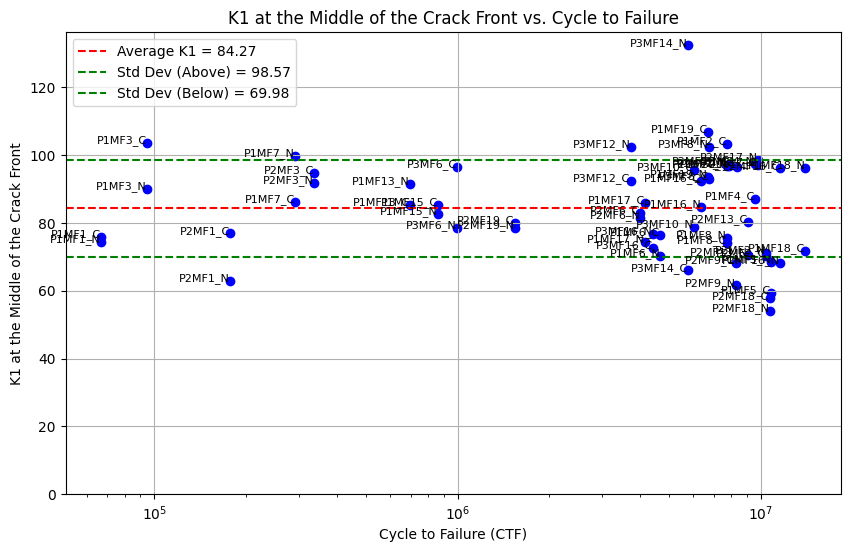

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data provided
data = {
    "img_name": ["P1MF13_N", "P1MF17_N", "P1MF19_N", "P1MF1_C", "P2MF17_C", "P2MF17_N", "P2MF18_C", 
                 "P2MF2_C", "P2MF9_N", "P3MF10_N", "P3MF12_C", "P3MF14_C", "P3MF8_N", "P1MF13_C", 
                 "P1MF15_C", "P1MF15_N", "P1MF16_C", "P1MF16_N", "P1MF17_C", "P1MF18_C", "P1MF18_N", 
                 "P1MF19_C", "P1MF1_N", "P1MF20_C", "P1MF2_C", "P1MF2_N", "P1MF3_C", "P1MF3_N", 
                 "P1MF4_C", "P1MF4_N", "P1MF5_C", "P1MF5_N", "P1MF6_C", "P1MF6_N", "P1MF7_C", 
                 "P1MF7_N", "P1MF8_C", "P1MF8_N", "P2MF13_C", "P2MF13_N", "P2MF16_C", "P2MF16_N", 
                 "P2MF18_N", "P2MF19_C", "P2MF19_N", "P2MF1_C", "P2MF1_N", "P2MF20_C", "P2MF20_N", 
                 "P2MF2_N", "P2MF3_C", "P2MF3_N", "P2MF6_C", "P2MF6_N", "P2MF9_C", "P3MF10_C", 
                 "P3MF12_N", "P3MF14_N", "P3MF16_C", "P3MF16_N", "P3MF6_C", "P3MF6_N", "P3MF8_C"],
    "CTF": [697367, 4158272, 6682405, 66623, 9758414, 9758414, 10694084, 10399595, 8268660, 6026850, 3722238, 5759186, 6736353, 
            697367, 858918, 858918, 6362897, 6362897, 4158272, 14042489, 14042489, 6682405, 66623, 8363945, 7759547, 7759547, 
            94390, 94390, 9579633, 9579633, 10847458, 10847458, 4662619, 4662619, 290696, 290696, 7751877, 7751877, 9059951, 
            9059951, 11550872, 11550872, 10694084, 1543883, 1543883, 177424, 177424, 7886707, 7886707, 10399595, 335993, 
            335993, 4012771, 4012771, 8268660, 6026850, 3722238, 5759186, 4413584, 4413584, 995614, 995614, 6736353],
    "K1_at_middle": [91.5434466, 74.38773192, 93.51167753, 75.73482796, 97.11103205, 98.56213322, 57.70685229, 
                     70.28272216, 61.54832741, 78.72159845, 92.46740062, 65.98515719, 102.3958325, 85.3578038, 
                     85.34901228, 82.55401562, 92.28688099, 84.74372956, 85.96970549, 71.77078843, 96.09481313, 
                     106.750971, 74.43924788, 96.5791656, 103.1736825, 96.67328848, 103.4615433, 90.09477212, 
                     87.02310089, 97.37352715, 59.33935164, 68.50948275, 76.35648921, 70.1238415, 86.25961374, 
                     99.77132798, 74.04301473, 75.61946772, 80.41054646, 70.55891165, 96.06966075, 68.19004284, 
                     53.97755565, 80.04607567, 78.4527257, 76.90160599, 62.93667164, 97.3553013, 96.66464096, 
                     71.02807821, 94.856608, 91.65989535, 82.94717492, 81.44641223, 68.13472692, 95.72846015, 
                     102.485402, 132.3502821, 72.64608015, 76.71300299, 96.62876285, 78.56604043, 92.87785632]
}

df = pd.DataFrame(data)

# Calculate the mean and standard deviation for K1 values
mean_K1 = np.mean(df['K1_at_middle'])
std_K1 = np.std(df['K1_at_middle'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(df['CTF'], df['K1_at_middle'], c='blue', marker='o')

# Plot the mean and standard deviation lines
plt.axhline(mean_K1, color='red', linestyle='--', label=f'Average K1 = {mean_K1:.2f}')
plt.axhline(mean_K1 + std_K1, color='green', linestyle='--', label=f'Std Dev (Above) = {mean_K1 + std_K1:.2f}')
plt.axhline(mean_K1 - std_K1, color='green', linestyle='--', label=f'Std Dev (Below) = {mean_K1 - std_K1:.2f}')

# Add labels, title, and legend
for i, txt in enumerate(df['img_name']):
    plt.annotate(txt, (df['CTF'][i], df['K1_at_middle'][i]), fontsize=8, ha='right')
plt.xlabel('Cycle to Failure (CTF)')
plt.ylabel('K1 at the Middle of the Crack Front')
plt.title('K1 at the Middle of the Crack Front vs. Cycle to Failure')
plt.grid(True)
plt.xscale('log')
plt.ylim(0)
plt.legend()
plt.show()


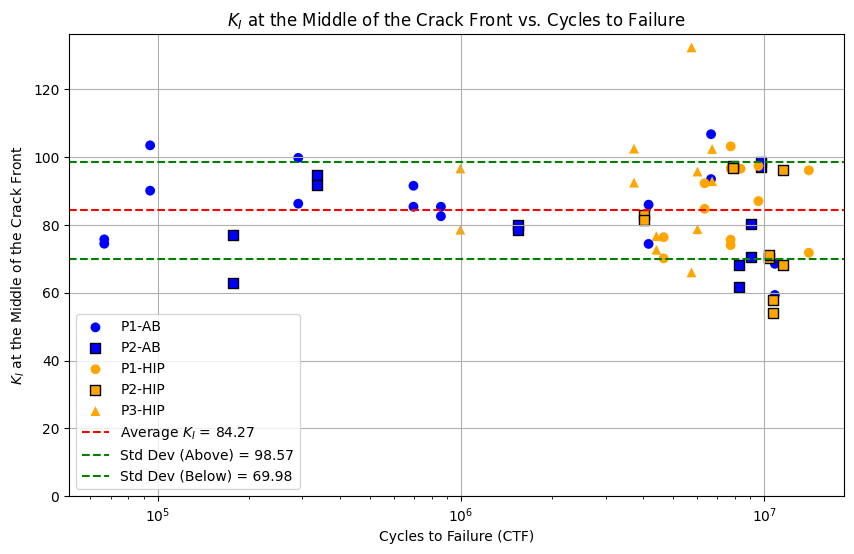

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data provided
data = {
    "img_name": ["P1MF13_N", "P1MF17_N", "P1MF19_N", "P1MF1_C", "P2MF17_C", "P2MF17_N", "P2MF18_C", 
                 "P2MF2_C", "P2MF9_N", "P3MF10_N", "P3MF12_C", "P3MF14_C", "P3MF8_N", "P1MF13_C", 
                 "P1MF15_C", "P1MF15_N", "P1MF16_C", "P1MF16_N", "P1MF17_C", "P1MF18_C", "P1MF18_N", 
                 "P1MF19_C", "P1MF1_N", "P1MF20_C", "P1MF2_C", "P1MF2_N", "P1MF3_C", "P1MF3_N", 
                 "P1MF4_C", "P1MF4_N", "P1MF5_C", "P1MF5_N", "P1MF6_C", "P1MF6_N", "P1MF7_C", 
                 "P1MF7_N", "P1MF8_C", "P1MF8_N", "P2MF13_C", "P2MF13_N", "P2MF16_C", "P2MF16_N", 
                 "P2MF18_N", "P2MF19_C", "P2MF19_N", "P2MF1_C", "P2MF1_N", "P2MF20_C", "P2MF20_N", 
                 "P2MF2_N", "P2MF3_C", "P2MF3_N", "P2MF6_C", "P2MF6_N", "P2MF9_C", "P3MF10_C", 
                 "P3MF12_N", "P3MF14_N", "P3MF16_C", "P3MF16_N", "P3MF6_C", "P3MF6_N", "P3MF8_C"],
    "CTF": [697367, 4158272, 6682405, 66623, 9758414, 9758414, 10694084, 10399595, 8268660, 6026850, 3722238, 5759186, 6736353, 
            697367, 858918, 858918, 6362897, 6362897, 4158272, 14042489, 14042489, 6682405, 66623, 8363945, 7759547, 7759547, 
            94390, 94390, 9579633, 9579633, 10847458, 10847458, 4662619, 4662619, 290696, 290696, 7751877, 7751877, 9059951, 
            9059951, 11550872, 11550872, 10694084, 1543883, 1543883, 177424, 177424, 7886707, 7886707, 10399595, 335993, 
            335993, 4012771, 4012771, 8268660, 6026850, 3722238, 5759186, 4413584, 4413584, 995614, 995614, 6736353],
    "K1_at_middle": [91.5434466, 74.38773192, 93.51167753, 75.73482796, 97.11103205, 98.56213322, 57.70685229, 
                     70.28272216, 61.54832741, 78.72159845, 92.46740062, 65.98515719, 102.3958325, 85.3578038, 
                     85.34901228, 82.55401562, 92.28688099, 84.74372956, 85.96970549, 71.77078843, 96.09481313, 
                     106.750971, 74.43924788, 96.5791656, 103.1736825, 96.67328848, 103.4615433, 90.09477212, 
                     87.02310089, 97.37352715, 59.33935164, 68.50948275, 76.35648921, 70.1238415, 86.25961374, 
                     99.77132798, 74.04301473, 75.61946772, 80.41054646, 70.55891165, 96.06966075, 68.19004284, 
                     53.97755565, 80.04607567, 78.4527257, 76.90160599, 62.93667164, 97.3553013, 96.66464096, 
                     71.02807821, 94.856608, 91.65989535, 82.94717492, 81.44641223, 68.13472692, 95.72846015, 
                     102.485402, 132.3502821, 72.64608015, 76.71300299, 96.62876285, 78.56604043, 92.87785632]
}

df = pd.DataFrame(data)

# Calculate the mean and standard deviation for K1 values
mean_K1 = np.mean(df['K1_at_middle'])
std_K1 = np.std(df['K1_at_middle'])

# Define the groupings for colors and markers
groups = {
    "P1-AB": ["P1MF1_C", "P1MF1_N", "P1MF13_C", "P1MF13_N", "P1MF15_C", "P1MF15_N", "P1MF17_C", "P1MF17_N", "P1MF19_C", "P1MF19_N", "P1MF3_C", "P1MF3_N", "P1MF5_C", "P1MF5_N", "P1MF7_C", "P1MF7_N"],
    "P2-AB": ["P2MF1_C", "P2MF1_N", "P2MF13_C", "P2MF13_N", "P2MF17_C", "P2MF17_N", "P2MF19_C", "P2MF19_N", "P2MF3_C", "P2MF3_N", "P2MF9_C", "P2MF9_N"],
    #"P3-AB": ["P3MF3_C", "P3MF3_N", "P3MF9_C", "P3MF9_N"],
    "P1-HIP": ["P1MF16_C", "P1MF16_N", "P1MF18_C", "P1MF18_N", "P1MF2_C", "P1MF2_N", "P1MF20_C", "P1MF4_C", "P1MF4_N", "P1MF6_C", "P1MF6_N", "P1MF8_C", "P1MF8_N"],
    "P2-HIP": ["P2MF16_C", "P2MF16_N", "P2MF18_C", "P2MF18_N", "P2MF2_C", "P2MF2_N", "P2MF20_C", "P2MF20_N", "P2MF6_C", "P2MF6_N"],
    "P3-HIP": ["P3MF10_C", "P3MF10_N", "P3MF12_C", "P3MF12_N", "P3MF14_C", "P3MF14_N", "P3MF16_C", "P3MF16_N", "P3MF6_C", "P3MF6_N", "P3MF8_C", "P3MF8_N"],
}

# Create the plot
plt.figure(figsize=(10, 6))

# Plot data points with three colors and different markers
colors = {'AB': 'blue', 'HIP': 'orange'}
markers = {'P1': 'o', 'P2': 's', 'P3': '^'}
for label, img_names in groups.items():
    df_group = df[df['img_name'].isin(img_names)]
    category = label.split('-')[0]
    marker_style = markers.get(label.split('-')[0], 'D')  # Default to diamond marker for 'Mixed'
    plt.scatter(df_group['CTF'], df_group['K1_at_middle'], 
                c=colors[label.split('-')[-1]], 
                label=label, 
                marker=marker_style, 
                s=50,
                edgecolors='black' if marker_style == 's' else 'none')  # Black edge for squares

# Plot the mean and standard deviation lines
plt.axhline(mean_K1, color='red', linestyle='--', label=f'Average $K_I$ = {mean_K1:.2f}')
plt.axhline(mean_K1 + std_K1, color='green', linestyle='--', label=f'Std Dev (Above) = {mean_K1 + std_K1:.2f}')
plt.axhline(mean_K1 - std_K1, color='green', linestyle='--', label=f'Std Dev (Below) = {mean_K1 - std_K1:.2f}')

# Add labels, title, and legend
plt.xlabel('Cycles to Failure (CTF)')
plt.ylabel('$K_I$ at the Middle of the Crack Front')
plt.title('$K_I$ at the Middle of the Crack Front vs. Cycles to Failure')
plt.grid(True)
plt.xscale('log')
plt.ylim(0)
plt.legend()
plt.show()


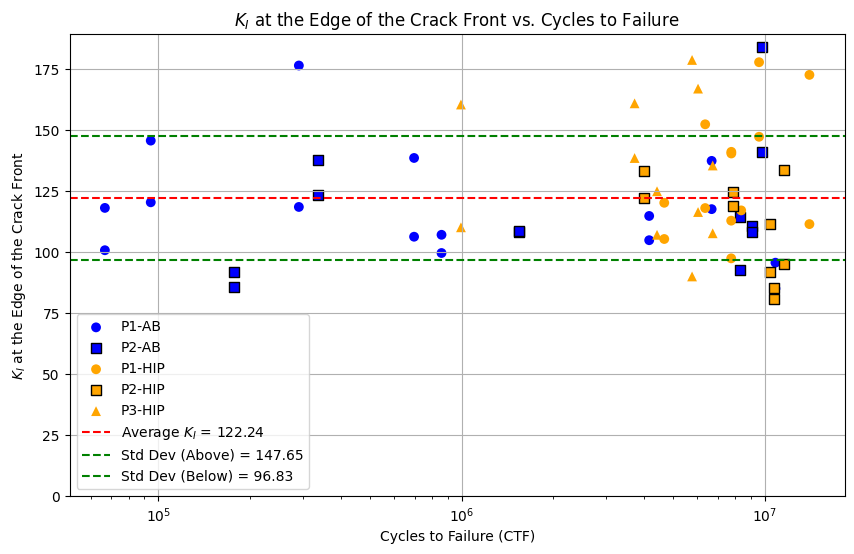

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# New data provided
data = {
    "img_name": ["P1MF13_N.png", "P1MF17_N.png", "P1MF19_N.png", "P1MF1_C.png", "P2MF17_C.png", "P2MF17_N.png", 
                 "P2MF18_C.png", "P2MF2_C.png", "P2MF9_N.png", "P3MF10_N.png", "P3MF12_C.png", "P3MF14_C.png", 
                 "P3MF8_N.png", "P1MF13_C.png", "P1MF15_C.png", "P1MF15_N.png", "P1MF16_C.png", "P1MF16_N.png", 
                 "P1MF17_C.png", "P1MF18_C.png", "P1MF18_N.png", "P1MF19_C.png", "P1MF1_N.png", "P1MF20_C.png", 
                 "P1MF2_C.png", "P1MF2_N.png", "P1MF3_C.png", "P1MF3_N.png", "P1MF4_C.png", "P1MF4_N.png", 
                 "P1MF5_C.png", "P1MF5_N.png", "P1MF6_C.png", "P1MF6_N.png", "P1MF7_C.png", "P1MF7_N.png", 
                 "P1MF8_C.png", "P1MF8_N.png", "P2MF13_C.png", "P2MF13_N.png", "P2MF16_C.png", "P2MF16_N.png", 
                 "P2MF18_N.png", "P2MF19_C.png", "P2MF19_N.png", "P2MF1_C.png", "P2MF1_N.png", "P2MF20_C.png", 
                 "P2MF20_N.png", "P2MF2_N.png", "P2MF3_C.png", "P2MF3_N.png", "P2MF6_C.png", "P2MF6_N.png", 
                 "P2MF9_C.png", "P3MF10_C.png", "P3MF12_N.png", "P3MF14_N.png", "P3MF16_C.png", "P3MF16_N.png", 
                 "P3MF6_C.png", "P3MF6_N.png", "P3MF8_C.png"],
    "CTF": [697367, 4158272, 6682405, 66623, 9758414, 9758414, 10694084, 10399595, 8268660, 6026850, 3722238, 5759186, 
            6736353, 697367, 858918, 858918, 6362897, 6362897, 4158272, 14042489, 14042489, 6682405, 66623, 8363945, 
            7759547, 7759547, 94390, 94390, 9579633, 9579633, 10847458, 10847458, 4662619, 4662619, 290696, 290696, 
            7751877, 7751877, 9059951, 9059951, 11550872, 11550872, 10694084, 1543883, 1543883, 177424, 177424, 7886707, 
            7886707, 10399595, 335993, 335993, 4012771, 4012771, 8268660, 6026850, 3722238, 5759186, 4413584, 4413584, 
            995614, 995614, 6736353],
    "K1_at_edge": [138.5544014, 114.7914217, 117.5854515, 118.0898375, 141.0039124, 184.1299952, 85.2348522, 
                   111.6877664, 92.54576105, 116.4034218, 160.9327832, 90.00540073, 135.4675781, 106.2823898, 
                   99.6092454, 107.0741991, 118.0270692, 152.3457205, 104.8575426, 111.4547427, 172.5963325, 
                   137.3573646, 100.750749, 117.0706123, 140.3884939, 141.0652962, 120.3873657, 145.659668, 
                   147.2366659, 177.7866373, 85.04768665, 95.64701539, 120.1871007, 105.3520167, 118.4823725, 
                   176.4356064, 112.8651061, 97.42116509, 110.7247247, 108.3739642, 133.6384669, 95.01268062, 
                   80.85611833, 108.1373251, 108.5015705, 85.66535874, 91.66751195, 119.0652137, 124.5058789, 
                   91.63399939, 123.5431, 137.6226001, 122.0994856, 133.3678678, 114.5225472, 166.9689413, 
                   138.5297291, 178.7100614, 124.9107923, 107.0674726, 160.4549497, 110.1420615, 107.6892168]
}

df = pd.DataFrame(data)

# Calculate the mean and standard deviation for K1 values
mean_K1 = np.mean(df['K1_at_edge'])
std_K1 = np.std(df['K1_at_edge'])

# Define the groupings for colors and markers
groups = {
    "P1-AB": ["P1MF1_C.png", "P1MF1_N.png", "P1MF13_C.png", "P1MF13_N.png", "P1MF15_C.png", "P1MF15_N.png", 
              "P1MF17_C.png", "P1MF17_N.png", "P1MF19_C.png", "P1MF19_N.png", "P1MF3_C.png", "P1MF3_N.png", 
              "P1MF5_C.png", "P1MF5_N.png", "P1MF7_C.png", "P1MF7_N.png"],
    "P2-AB": ["P2MF1_C.png", "P2MF1_N.png", "P2MF13_C.png", "P2MF13_N.png", "P2MF17_C.png", "P2MF17_N.png", 
              "P2MF19_C.png", "P2MF19_N.png", "P2MF3_C.png", "P2MF3_N.png", "P2MF9_C.png", "P2MF9_N.png"],
    #"P3-AB": ["P3MF3_C.png", "P3MF3_N.png", "P3MF9_C.png", "P3MF9_N.png"],
    "P1-HIP": ["P1MF16_C.png", "P1MF16_N.png", "P1MF18_C.png", "P1MF18_N.png", "P1MF2_C.png", "P1MF2_N.png", 
               "P1MF20_C.png", "P1MF4_C.png", "P1MF4_N.png", "P1MF6_C.png", "P1MF6_N.png", "P1MF8_C.png", 
               "P1MF8_N.png"],
    "P2-HIP": ["P2MF16_C.png", "P2MF16_N.png", "P2MF18_C.png", "P2MF18_N.png", "P2MF2_C.png", "P2MF2_N.png", 
               "P2MF20_C.png", "P2MF20_N.png", "P2MF6_C.png", "P2MF6_N.png"],
    "P3-HIP": ["P3MF10_C.png", "P3MF10_N.png", "P3MF12_C.png", "P3MF12_N.png", "P3MF14_C.png", "P3MF14_N.png", 
               "P3MF16_C.png", "P3MF16_N.png", "P3MF6_C.png", "P3MF6_N.png", "P3MF8_C.png", "P3MF8_N.png"]
}

# Create the plot
plt.figure(figsize=(10, 6))

# Plot data points with colors and different markers
colors = {'AB': 'blue', 'HIP': 'orange'}
markers = {'P1': 'o', 'P2': 's', 'P3': '^'}

for label, img_names in groups.items():
    df_group = df[df['img_name'].isin(img_names)]
    category = label.split('-')[1]
    marker_style = markers.get(label.split('-')[0], 'D')  # Default to diamond marker if not found
    
    plt.scatter(df_group['CTF'], df_group['K1_at_edge'], 
                c=colors[category], 
                label=label, 
                marker=marker_style, 
                s=50, 
                edgecolors='black' if marker_style == 's' else 'none')  # Black edge for squares

# Plot the mean and standard deviation lines
plt.axhline(mean_K1, color='red', linestyle='--', label=f'Average $K_I$ = {mean_K1:.2f}')
plt.axhline(mean_K1 + std_K1, color='green', linestyle='--', label=f'Std Dev (Above) = {mean_K1 + std_K1:.2f}')
plt.axhline(mean_K1 - std_K1, color='green', linestyle='--', label=f'Std Dev (Below) = {mean_K1 - std_K1:.2f}')

# Add labels, title, and legend
plt.xlabel('Cycles to Failure (CTF)')
plt.ylabel(r'$K_I$ at the Edge of the Crack Front')
plt.title(r'$K_I$ at the Edge of the Crack Front vs. Cycles to Failure')
plt.grid(True)
plt.xscale('log')
plt.ylim(0)
plt.legend()
plt.show()


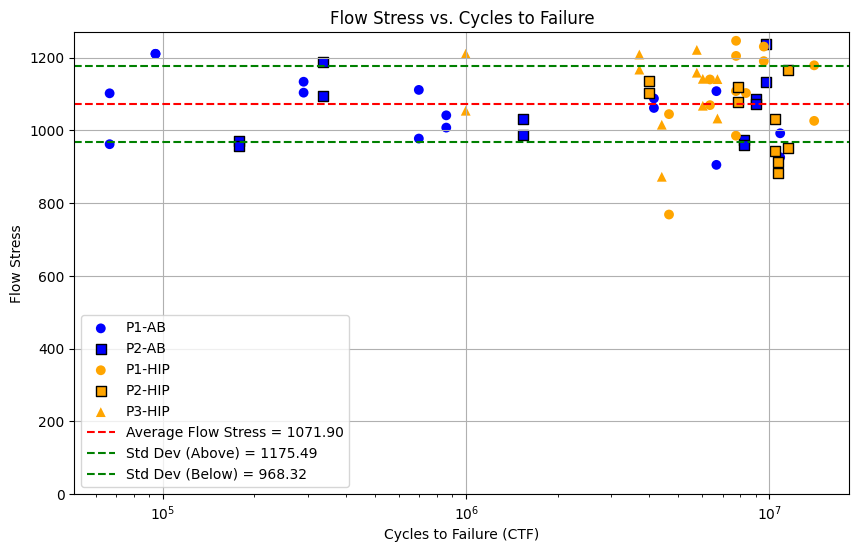

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# New data provided for flow stress
data = {
    "img_name": ["P1MF13_N.png", "P1MF17_N.png", "P1MF19_N.png", "P1MF1_C.png", "P2MF17_C.png", "P2MF17_N.png", 
                 "P2MF18_C.png", "P2MF2_C.png", "P2MF9_N.png", "P3MF10_N.png", "P3MF12_C.png", "P3MF14_C.png", 
                 "P3MF8_N.png", "P1MF13_C.png", "P1MF15_C.png", "P1MF15_N.png", "P1MF16_C.png", "P1MF16_N.png", 
                 "P1MF17_C.png", "P1MF18_C.png", "P1MF18_N.png", "P1MF19_C.png", "P1MF1_N.png", "P1MF20_C.png", 
                 "P1MF2_C.png", "P1MF2_N.png", "P1MF3_C.png", "P1MF3_N.png", "P1MF4_C.png", "P1MF4_N.png", 
                 "P1MF5_C.png", "P1MF5_N.png", "P1MF6_C.png", "P1MF6_N.png", "P1MF7_C.png", "P1MF7_N.png", 
                 "P1MF8_C.png", "P1MF8_N.png", "P2MF13_C.png", "P2MF13_N.png", "P2MF16_C.png", "P2MF16_N.png", 
                 "P2MF18_N.png", "P2MF19_C.png", "P2MF19_N.png", "P2MF1_C.png", "P2MF1_N.png", "P2MF20_C.png", 
                 "P2MF20_N.png", "P2MF2_N.png", "P2MF3_C.png", "P2MF3_N.png", "P2MF6_C.png", "P2MF6_N.png", 
                 "P2MF9_C.png", "P3MF10_C.png", "P3MF12_N.png", "P3MF14_N.png", "P3MF16_C.png", "P3MF16_N.png", 
                 "P3MF6_C.png", "P3MF6_N.png", "P3MF8_C.png"],
    "CTF": [697367, 4158272, 6682405, 66623, 9758414, 9758414, 10694084, 10399595, 8268660, 6026850, 3722238, 5759186, 
            6736353, 697367, 858918, 858918, 6362897, 6362897, 4158272, 14042489, 14042489, 6682405, 66623, 8363945, 
            7759547, 7759547, 94390, 94390, 9579633, 9579633, 10847458, 10847458, 4662619, 4662619, 290696, 290696, 
            7751877, 7751877, 9059951, 9059951, 11550872, 11550872, 10694084, 1543883, 1543883, 177424, 177424, 7886707, 
            7886707, 10399595, 335993, 335993, 4012771, 4012771, 8268660, 6026850, 3722238, 5759186, 4413584, 4413584, 
            995614, 995614, 6736353],
    "flow_stress": [1111.007416, 1087.56093, 904.9897143, 1101.648607, 1236.379357, 1132.578101, 914.1637342, 
                    1031.744083, 974.3340149, 1067.481717, 1166.806251, 1158.292044, 1140.658878, 977.2854778, 
                    1007.392397, 1041.113108, 1139.748092, 1069.14429, 1061.422892, 1025.91771, 1178.555778, 
                    1107.592331, 961.7829412, 1102.447371, 1204.457341, 1245.961773, 1210.111597, 1210.175727, 
                    1190.056524, 1230.144805, 925.8653609, 991.7731617, 1044.441874, 768.4827511, 1133.445083, 
                    1103.454807, 1107.793405, 985.183901, 1086.368164, 1072.268456, 1165.78119, 951.5033199, 
                    883.3747418, 986.5005965, 1032.031341, 971.4508377, 956.9637571, 1078.723822, 1118.643248, 
                    942.4958782, 1094.789032, 1186.890835, 1135.750818, 1101.765709, 958.4945993, 1141.448851, 
                    1208.254552, 1221.016388, 872.2191615, 1015.260426, 1210.400549, 1053.774209, 1032.388088]
}

df = pd.DataFrame(data)

# Calculate the mean and standard deviation for flow stress values
mean_flow_stress = np.mean(df['flow_stress'])
std_flow_stress = np.std(df['flow_stress'])

# Define the groupings for colors and markers
groups = {
    "P1-AB": ["P1MF1_C.png", "P1MF1_N.png", "P1MF13_C.png", "P1MF13_N.png", "P1MF15_C.png", "P1MF15_N.png", 
              "P1MF17_C.png", "P1MF17_N.png", "P1MF19_C.png", "P1MF19_N.png", "P1MF3_C.png", "P1MF3_N.png", 
              "P1MF5_C.png", "P1MF5_N.png", "P1MF7_C.png", "P1MF7_N.png"],
    "P2-AB": ["P2MF1_C.png", "P2MF1_N.png", "P2MF13_C.png", "P2MF13_N.png", "P2MF17_C.png", "P2MF17_N.png", 
              "P2MF19_C.png", "P2MF19_N.png", "P2MF3_C.png", "P2MF3_N.png", "P2MF9_C.png", "P2MF9_N.png"],
    "P1-HIP": ["P1MF16_C.png", "P1MF16_N.png", "P1MF18_C.png", "P1MF18_N.png", "P1MF2_C.png", "P1MF2_N.png", 
               "P1MF20_C.png", "P1MF4_C.png", "P1MF4_N.png", "P1MF6_C.png", "P1MF6_N.png", "P1MF8_C.png", 
               "P1MF8_N.png"],
    "P2-HIP": ["P2MF16_C.png", "P2MF16_N.png", "P2MF18_C.png", "P2MF18_N.png", "P2MF2_C.png", "P2MF2_N.png", 
               "P2MF20_C.png", "P2MF20_N.png", "P2MF6_C.png", "P2MF6_N.png"],
    "P3-HIP": ["P3MF10_C.png", "P3MF10_N.png", "P3MF12_C.png", "P3MF12_N.png", "P3MF14_C.png", "P3MF14_N.png", 
               "P3MF16_C.png", "P3MF16_N.png", "P3MF6_C.png", "P3MF6_N.png", "P3MF8_C.png", "P3MF8_N.png"]
}

# Create the plot
plt.figure(figsize=(10, 6))

# Plot data points with colors and different markers
colors = {'AB': 'blue', 'HIP': 'orange'}
markers = {'P1': 'o', 'P2': 's', 'P3': '^'}

for label, img_names in groups.items():
    df_group = df[df['img_name'].isin(img_names)]
    category = label.split('-')[1]
    marker_style = markers.get(label.split('-')[0], 'D')  # Default to diamond marker if not found
    
    plt.scatter(df_group['CTF'], df_group['flow_stress'], 
                c=colors[category], 
                label=label, 
                marker=marker_style, 
                s=50, 
                edgecolors='black' if marker_style == 's' else 'none')  # Black edge for squares

# Plot the mean and standard deviation lines
plt.axhline(mean_flow_stress, color='red', linestyle='--', label=f'Average Flow Stress = {mean_flow_stress:.2f}')
plt.axhline(mean_flow_stress + std_flow_stress, color='green', linestyle='--', label=f'Std Dev (Above) = {mean_flow_stress + std_flow_stress:.2f}')
plt.axhline(mean_flow_stress - std_flow_stress, color='green', linestyle='--', label=f'Std Dev (Below) = {mean_flow_stress - std_flow_stress:.2f}')

# Add labels, title, and legend
plt.xlabel('Cycles to Failure (CTF)')
plt.ylabel('Flow Stress')
plt.title('Flow Stress vs. Cycles to Failure')
plt.grid(True)
plt.xscale('log')
plt.ylim(0)
plt.legend()
plt.show()
